In [1]:
import torch
import torch.nn as nn

import sys

sys.path.insert(0, "..")
from utils.checkpoint import CheckPointer
from models.encoder import Encoder
from models.decoder import FrameLSTM, EventLSTM
from models.attention import Attention1, Attention2, Attention3
from models.models import Model4

from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import glob
import os

from PIL import Image
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import glob
import pickle

In [2]:
joint_details = {
    1: "HEAD",
    2: "NECK",
    3: "TORSO",
    4: "LEFT_SHOULDER",
    5: "LEFT_ELBOW",
    6: "LEFT_HAND",
    7: "RIGHT_SHOULDER",
    8: "RIGHT_ELBOW",
    9: "RIGHT_HAND",
    10: "LEFT_HIP",
    11: "LEFT_KNEE",
    12: "LEFT_FOOT",
    13: "RIGHT_HIP",
    14: "RIGHT_KNEE",
    15: "RIGHT_FOOT",
}
connect_map = [
    [1, 2, 2, 2, 3, 3, 3, 3, 4, 5, 7, 8, 10, 11, 13, 14],
    [2, 3, 4, 7, 4, 7, 10, 13, 5, 6, 8, 9, 11, 12, 14, 15],
]


def plot_frames(frames_code, reqd_pose_data, frames_pth, acts):

    frames_code = [int(x) for x in frames_code.strip().split("-")]

    for idx, row in enumerate(reqd_pose_data):
        posture = row

        posture_data = [x.strip() for x in posture.split(",")]

        joint_info = {}
        for i, n in enumerate(range(1, len(posture_data), 3)):
            x = 640 - float(posture_data[n]) * 640
            y = 480 - (float(posture_data[n + 1]) / 1) * 480
            z = posture_data[n + 2]

            joint_info[i + 1] = [x, y, z]

        person_1 = {k: joint_info[k] for k in range(1, 16, 1)}
        # print(person_1)
        person_2 = {k - 15: joint_info[k] for k in range(16, 31, 1)}
        # print(person_1)

        count1 = 15
        for i, (x, y, z) in list(person_1.items()):
            if x < 0 or x > 640 or y < 0 or y > 480:
                count1 -= 1

        count2 = 15
        for i, (x, y, z) in list(person_2.items()):
            if x < 0 or x > 640 or y < 0 or y > 480:
                count2 -= 1

        wt1, wt2 = acts[idx][0], acts[idx][1]

        #         if frames_code[2]==2:
        #             wt1, wt2 = wt2, wt1

        print(wt1, wt2)
        for key, value in person_1.items():
            plt.plot(value[0], value[1], "bo", markersize=2)
        for m, n in zip(connect_map[0], connect_map[1]):
            plt.plot(
                (person_1[m][0], person_1[n][0]),
                (person_1[m][1], person_1[n][1]),
                "b--",
                linewidth=5 * wt1,
            )

        for key, value in person_2.items():
            plt.plot(value[0], value[1], "go", markersize=2)
        for m, n in zip(connect_map[0], connect_map[1]):
            plt.plot(
                (person_2[m][0], person_2[n][0]),
                (person_2[m][1], person_2[n][1]),
                "g--",
                linewidth=5 * wt2,
            )

        plt.xlim(0, 640)
        plt.ylim(0, 480)

        img = np.array(plt.imread(frames_pth[idx]))
        img = img[::-1, :, :]
        plt.imshow(img)
        plt.pause(0.1)
        plt.clf()

In [3]:
# model_pth = '/usr/local/data01/rohitram/sbu-snapshots/model4/d=F,seed=default,framew=default,framefb=default,eventw=default,eventfb=default,lr=5e-05,ep=200/no_scheduler/fold=1/run=2/Jul20_06-36-39/best.pth'

model_pth = "/usr/local/data01/rohitram/sbu-snapshots/model4/d=F,seed=default,f_w=default,f_fb=default,f_h=167,e_w=default,e_fb=default,e_h=179,lr=0.002052,ep=200/fold=1/run=1/Aug02_01-32-07/best.pth"

model = Model4(
    frameLSTM={"hidden_size": 167},
    CNN_embed_dim=256,
    eventLSTM={"hidden_size": 179},
    pose_dim=30,
    num_classes=8,
    attention_params={"hidden_size": 64, "bias": None},
)
ckpt = CheckPointer([model])
ckpt.load_checkpoint(model_pth)

model.cuda()

Loading checkpoint from /usr/local/data01/rohitram/sbu-snapshots/model4/d=F,seed=default,f_w=default,f_fb=default,f_h=167,e_w=default,e_fb=default,e_h=179,lr=0.002052,ep=200/fold=1/run=1/Aug02_01-32-07/best.pth
current best metrics {'val_accuracy': tensor(0.6909, device='cuda:0'), 'val_loss': 1.069747239893133}


Model4(
  (encoder): Encoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (d

In [4]:
def get_weights(name):
    def hook(model, input, output):
        print(output[1])
        activation[name].append(output[1][0].detach().cpu().numpy())

    return hook


model.attention.register_forward_hook(get_weights("attention"))

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [6]:
reqd_pose_data = None
rgb_images = None
start = None
end = None


def get_model_inp(frames_code):
    global reqd_pose_data, rgb_images, start, end

    dataset_pth = "/usr/local/data02/dpdataset/sbu/"

    set_no, action, run = [int(x) for x in frames_code.strip().split("-")]

    part_sets = sorted(os.listdir(dataset_pth))
    part_name = part_sets[set_no - 1]
    set_no = "%02d" % action
    run = "%03d" % run

    frames_pth = os.path.join(dataset_pth, part_name, set_no, run)
    rgb_images = sorted(glob.glob(f"{frames_pth}/rgb*"))

    select_frames = 10
    start = (len(rgb_images) - select_frames) // 2
    end = start + select_frames

    req_images = rgb_images[start:end]
    read_images = [Image.open(x).convert("RGB") for x in req_images]
    transformed_images = [transform(x) for x in read_images]
    img_inp = torch.stack(transformed_images)
    img_inp.unsqueeze_(0)

    with open(os.path.join(frames_pth, "skeleton_pos.txt"), "r") as f:
        pose_data = f.readlines()

    reqd_pose_data = pose_data[start:end]

    video_pose_values = []
    for row in reqd_pose_data:
        posture_data = [x.strip() for x in row.split(",")]
        frame_pose_values = [float(x) for x in posture_data[1:]]
        assert len(frame_pose_values) == 90, "incorrect number of pose values"
        video_pose_values.append(frame_pose_values)

    video_pose_values = torch.tensor(video_pose_values, dtype=torch.float32)

    idxs = torch.tensor([i for i in range(90) if (i + 1) % 3 != 0])
    loaded_poses = video_pose_values[:, idxs]
    keypoints_per_person = 30

    pose_values = loaded_poses.view(loaded_poses.shape[0], 2, keypoints_per_person)

    pose_inp = pose_values.unsqueeze(0)
    pose_inp = pose_inp.cuda()
    img_inp = img_inp.cuda()

    return (img_inp, pose_inp)

tensor([[9.9999e-01, 1.0873e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9998e-01, 1.6710e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9998e-01, 1.8730e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9998e-01, 1.7283e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9997e-01, 3.0748e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9998e-01, 2.1418e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9999e-01, 1.3587e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9999e-01, 1.0395e-05]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9999e-01, 7.0937e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[9.9999e-01, 6.0067e-06]], device='cuda:0', grad_fn=<SoftmaxBackward>)
0.99998915 1.0872551e-05


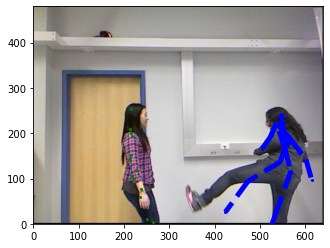

0.9999833 1.6709564e-05


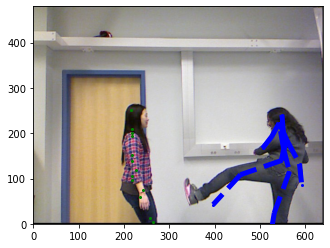

0.9999813 1.87298e-05


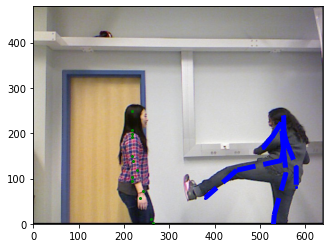

0.9999827 1.7282624e-05


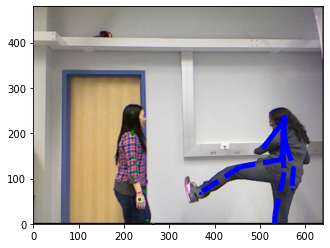

0.99996924 3.074814e-05


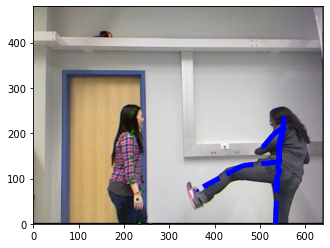

0.99997854 2.1417602e-05


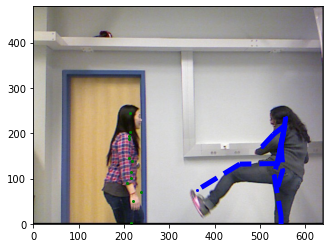

0.9999864 1.3587231e-05


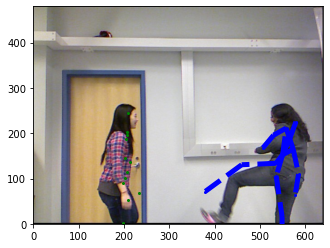

0.9999896 1.0395047e-05


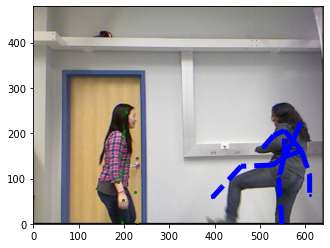

0.99999285 7.0937053e-06


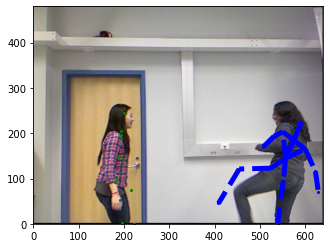

0.99999404 6.0066845e-06


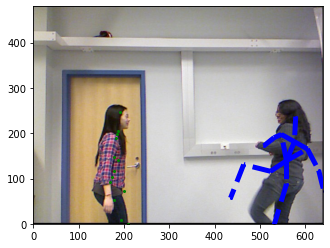

<Figure size 432x288 with 0 Axes>

In [18]:
# set (1-21) - action (1-8) - participant_run (1/2/3)
# frames_code = '8-3-1' #kicking
# frames_code = '3-8-1' #punching
frames_code = "18-3-2"  # fold=1 test sets = 1,9,15,19


activation = {"attention": []}
output = model(*get_model_inp(frames_code))

plot_frames(frames_code, reqd_pose_data, rgb_images[start:end], activation["attention"])